<a href="https://colab.research.google.com/github/zahwaardiansyah04/Deep-Learning-Lanjut/blob/main/Tugas_Deep_Learning_Pertemuan_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

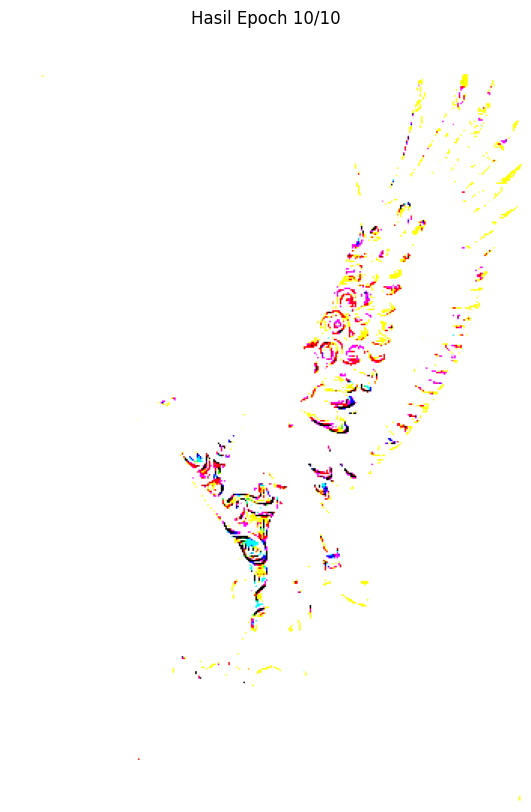

Pelatihan Selesai! Waktu total: 1.16 menit.

--- HASIL AKHIR ---


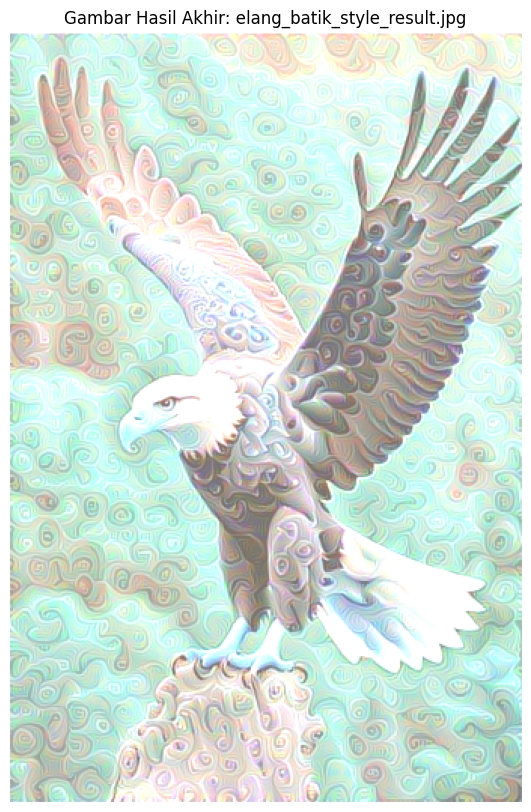

Gambar hasil telah disimpan sebagai elang_batik_style_result.jpg di Google Colab Anda.


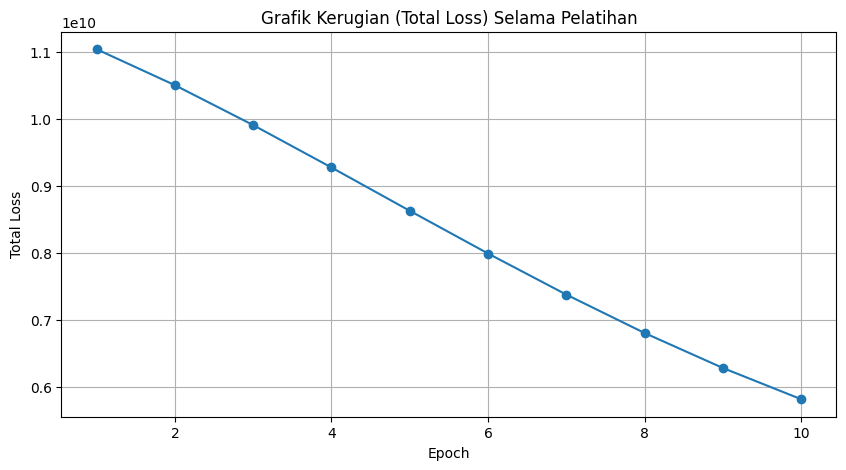

In [2]:
import tensorflow as tf
import numpy as np
import time
import IPython.display as display

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Menggunakan VGG19 yang telah dilatih pada ImageNet untuk mengekstrak fitur gaya dan konten
# VGG19 dipilih karena arsitekturnya yang sederhana dan efektif dalam NST.
# 'include_top=False' agar kita hanya menggunakan lapisan konvolusional (extractor fitur).
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False # Pastikan model VGG tidak dilatih

# ------------------------------------------------------------------------------
# 1. Definisi Lapisan (Layers)
# ------------------------------------------------------------------------------

# Lapisan untuk ekstraksi fitur Konten (Content)
CONTENT_LAYERS = ['block5_conv2']

# Lapisan untuk ekstraksi fitur Gaya (Style)
STYLE_LAYERS = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

# Total jumlah lapisan gaya
num_style_layers = len(STYLE_LAYERS)

# ------------------------------------------------------------------------------
# 2. Fungsi Pembantu Pra-Pemrosesan (Pre-processing) Gambar
# ------------------------------------------------------------------------------

def load_img(path_to_img):
    """Memuat gambar dan mengubah ukurannya agar sesuai dengan resolusi target."""
    max_dim = 512
    img = Image.open(path_to_img)

    # Menghitung faktor skala untuk membatasi dimensi terpanjang ke max_dim
    long = max(img.size)
    scale = max_dim / long
    new_size = (int(img.size[0] * scale), int(img.size[1] * scale))
    img = img.resize(new_size, Image.Resampling.LANCZOS)

    # Mengubah gambar PIL menjadi tensor TensorFlow
    img = np.array(img, dtype=np.float32)
    # Menambahkan dimensi batch (1, H, W, C)
    img = img[tf.newaxis, ...]

    return img

def preprocess_image(image):
    """
    Pra-pemrosesan gambar yang sesuai dengan VGG19 (standarisasi RGB).
    VGG19 dilatih dengan gambar-gambar yang sudah dinormalisasi dengan
    mean-pixel ImageNet.
    """
    # Menyalin tensor agar operasi pra-pemrosesan tidak mengubah tensor asli
    image = tf.identity(image)
    # Mengubah dari RGB ke BGR (standar VGG)
    # image = image[:, :, :, ::-1] # VGG asli menggunakan BGR, tetapi tf.keras.applications.vgg19.preprocess_input mengurus ini

    # Menggunakan fungsi pra-pemrosesan bawaan TensorFlow/Keras
    return tf.keras.applications.vgg19.preprocess_input(image)

def deprocess_image(processed_img):
    """
    Pasca-pemrosesan tensor gambar kembali ke format yang dapat ditampilkan (0-255).
    """
    x = processed_img.copy()
    if len(x.shape) == 4:
        # Menghapus dimensi batch jika ada
        x = np.squeeze(x, axis=0)

    # Mengembalikan normalisasi: membalikkan operasi mean-subtraction dan BGR-to-RGB
    # Nilai mean VGG19 ImageNet: [103.939, 116.779, 123.68] (BGR)

    # Tambahkan kembali nilai mean untuk channel B, G, R
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # Mengubah kembali ke RGB (membalikkan BGR)
    x = x[:, :, ::-1]

    # Memastikan nilai piksel berada dalam rentang [0, 255] dan mengubah tipe data
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def show_img(img, title=None):
    """Menampilkan gambar menggunakan matplotlib."""
    # Menghapus dimensi batch jika ada
    if len(img.shape) == 4:
         img = np.squeeze(img, axis=0)

    # Jika gambar belum dide-proses, lakukan de-proses
    if img.max() > 255:
        img = deprocess_image(img.numpy())

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# ------------------------------------------------------------------------------
# 3. Fungsi Komputasi Kerugian (Loss Functions)
# ------------------------------------------------------------------------------

def content_loss(base_content, target_content):
    """
    Menghitung kerugian konten (Content Loss).
    Kerugian ini adalah kuadrat rata-rata error (MSE) antara fitur gambar konten dan gambar yang dihasilkan.
    Tujuannya: Memastikan gambar yang dihasilkan memiliki konten yang sama dengan gambar konten.
    """
    return tf.reduce_mean(tf.square(base_content - target_content))

def gram_matrix(input_tensor):
    """
    Menghitung Gram Matrix dari tensor fitur.
    Gram Matrix adalah produk dalam (inner product) dari tensor fitur dengan dirinya sendiri,
    yang menangkap korelasi spasial antar fitur, yang dianggap sebagai 'gaya' gambar.
    """
    # Awalnya, input_tensor memiliki bentuk (1, H, W, C)
    # Flatten: Mengubah tensor menjadi (C, H * W), di mana C adalah jumlah channel
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

    # Mendapatkan tinggi, lebar, dan jumlah channel
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    # Normalisasi dengan membagi dengan jumlah lokasi (H * W)
    return result / num_locations

def style_loss(base_gram_matrix, target_gram_matrix):
    """
    Menghitung kerugian gaya (Style Loss).
    Kerugian ini adalah MSE antara Gram Matrix dari fitur gambar gaya dan gambar yang dihasilkan.
    Tujuannya: Memastikan gambar yang dihasilkan memiliki tekstur dan warna yang sama dengan gambar gaya.
    """
    # Langsung menghitung MSE antara kedua Gram Matrix yang sudah diberikan
    return tf.reduce_mean(tf.square(base_gram_matrix - target_gram_matrix))

# ------------------------------------------------------------------------------
# 4. Model Ekstraksi Fitur
# ------------------------------------------------------------------------------

def vgg_layers(layer_names):
    """
    Membuat model Keras yang mengembalikan output dari lapisan-lapisan yang ditentukan
    dari VGG19.
    """
    # Memuat VGG19 lagi (pastikan weights='imagenet' dan include_top=False)
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    # Model Keras baru yang mengambil input VGG dan mengembalikan output dari
    # lapisan yang dipilih
    model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
    return model

# Model untuk mendapatkan fitur konten dan gaya
style_extractor = vgg_layers(STYLE_LAYERS)
content_extractor = vgg_layers(CONTENT_LAYERS)

# ------------------------------------------------------------------------------
# 5. Model Style Transfer Penuh
# ------------------------------------------------------------------------------

class StyleContentModel(tf.keras.models.Model):
    """
    Model Keras yang mengembalikan fitur gaya dan konten dari input gambar.
    """
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        # Menggabungkan semua lapisan yang dibutuhkan
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False # Pastikan VGG tidak dilatih

    def call(self, inputs):
        """
        Input dipra-proses, dilewatkan melalui VGG, dan fitur dibagi menjadi
        fitur gaya (Gram Matrix) dan fitur konten.
        """
        # Pra-pemrosesan input (normalisasi, dll.)
        inputs = preprocess_image(inputs)
        # Mendapatkan semua output fitur (gaya dan konten)
        outputs = self.vgg(inputs)

        # Membagi output menjadi fitur gaya dan konten
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]

        # Menghitung Gram Matrix untuk setiap lapisan gaya
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        # Mengembalikan dictionary fitur
        style_dict = {name: value
                      for name, value in zip(self.style_layers, style_outputs)}
        content_dict = {name: value
                        for name, value in zip(self.content_layers, content_outputs)}

        return {'content': content_dict, 'style': style_dict}


# ------------------------------------------------------------------------------
# 6. Menyiapkan Gambar dan Target
# ------------------------------------------------------------------------------

# Tentukan nama file yang diunggah
content_path = 'elang.jpg'
style_path = 'batik.jpg'

# Memuat dan menampilkan gambar input
content_image = load_img(content_path)
style_image = load_img(style_path)

show_img(content_image, 'Gambar Konten (Struktur): Elang')
show_img(style_image, 'Gambar Gaya (Tekstur): Batik')

# Inisialisasi model
extractor = StyleContentModel(STYLE_LAYERS, CONTENT_LAYERS)

# Mendapatkan target fitur gaya dan konten
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

# Gambar hasil yang akan dioptimalkan (dimulai dari gambar konten)
# Menggunakan tf.Variable agar tensor dapat diubah selama optimasi
image = tf.Variable(content_image)

# ------------------------------------------------------------------------------
# 7. Fungsi Kerugian Total dan Optimasi
# ------------------------------------------------------------------------------

# Bobot untuk menyeimbangkan kerugian konten dan gaya
# Bobot gaya biasanya jauh lebih tinggi daripada bobot konten
style_weight = 1e-2 # Bobot untuk Style Loss
content_weight = 1e4 # Bobot untuk Content Loss

# Optimizer: Adam adalah pilihan yang baik untuk masalah optimasi bergambar
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)


@tf.function()
def train_step(image):
    """
    Satu langkah optimasi:
    1. Hitung kerugian (Loss)
    2. Hitung gradien
    3. Terapkan gradien
    """
    with tf.GradientTape() as tape:
        # Menghitung fitur saat ini
        model_outputs = extractor(image)

        # Inisialisasi kerugian
        loss = tf.constant(0.0)

        # 1. Menghitung Style Loss (kerugian gaya)
        style_score = tf.constant(0.0)
        # Menjumlahkan kerugian dari semua lapisan gaya
        for name in STYLE_LAYERS:
            style_score += style_loss(model_outputs['style'][name], style_targets[name])

        # Menambahkan bobot ke Style Loss
        style_score *= style_weight / num_style_layers

        # 2. Menghitung Content Loss (kerugian konten)
        content_score = tf.constant(0.0)
        # Menjumlahkan kerugian dari semua lapisan konten
        for name in CONTENT_LAYERS:
            content_score += content_loss(model_outputs['content'][name], content_targets[name])

        # Menambahkan bobot ke Content Loss
        content_score *= content_weight

        # 3. Kerugian Total: Gaya + Konten
        loss += style_score + content_score

    # Menghitung gradien kerugian terhadap gambar yang dioptimalkan
    grad = tape.gradient(loss, image)

    # Menerapkan gradien untuk memperbarui gambar
    opt.apply_gradients([(grad, image)])

    # Memastikan nilai piksel gambar tetap dalam rentang VGG (sedikit di atas 0)
    image.assign(tf.clip_by_value(image, 0., 255.))

    return loss, style_score, content_score

# ------------------------------------------------------------------------------
# 8. Pelatihan (Training)
# ------------------------------------------------------------------------------

epochs = 10
steps_per_epoch = 100
total_steps = epochs * steps_per_epoch

print(f"Memulai pelatihan selama {epochs} epochs dengan {steps_per_epoch} langkah per epoch (Total {total_steps} langkah)...")
start = time.time()

# Untuk melacak kerugian
history = []

for epoch in range(epochs):
    for step in range(steps_per_epoch):
        # Lakukan satu langkah optimasi
        total_loss, style_score, content_score = train_step(image)

        # Tampilkan status pelatihan setiap 100 langkah
        if (step + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Langkah {step+1}/{steps_per_epoch}: Loss={total_loss.numpy():.2f}, Style={style_score.numpy():.2f}, Content={content_score.numpy():.2f}")

    # Tampilkan gambar hasil setiap akhir epoch
    display.clear_output(wait=True)
    show_img(image.read_value(), f"Hasil Epoch {epoch+1}/{epochs}")
    history.append(total_loss.numpy())

end = time.time()
print(f"Pelatihan Selesai! Waktu total: {(end-start)/60:.2f} menit.")

# ------------------------------------------------------------------------------
# 9. Menyimpan Hasil Akhir
# ------------------------------------------------------------------------------

final_image = deprocess_image(image.numpy())
img = Image.fromarray(final_image)
output_filename = 'elang_batik_style_result.jpg'
img.save(output_filename)

print(f"\n--- HASIL AKHIR ---")
show_img(final_image, f"Gambar Hasil Akhir: {output_filename}")
print(f"Gambar hasil telah disimpan sebagai {output_filename} di Google Colab Anda.")

# Tampilkan plot kerugian (optional)
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), history, marker='o', linestyle='-')
plt.title('Grafik Kerugian (Total Loss) Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.grid(True)
plt.show()